# Import Needed Libraries

In [6]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [4]:
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [12]:
# loading the data
data_dir = 'C:/Users/Mahak Gupta/Downloads/lung_colon_image_set/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths  \
0      C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
1      C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
2      C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
3      C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
4      C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
...                                                  ...   
14995  C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
14996  C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
14997  C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
14998  C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   
14999  C:/Users/Mahak Gupta/Downloads/lung_colon_imag...   

                             labels  
0               Lung_adenocarcinoma  
1               Lung_adenocarcinoma  
2               Lung_adenocarcinoma  
3               Lung_adenocarcinoma  
4               Lung_adenocarcinoma  
...                             ...  
14995  Lung squamous_cell_carcinoma  
14996  Lung squamous_cell_carcinoma  
14997  Lung squamous_cell_carcinoma  
14998  Lung squamous_cell_carcinoma  
14999  Lung squamous_cell_carcinoma  

[15000 rows x 2 columns]

# Data preprocessing

#### First we will check if the training data is balanced or not

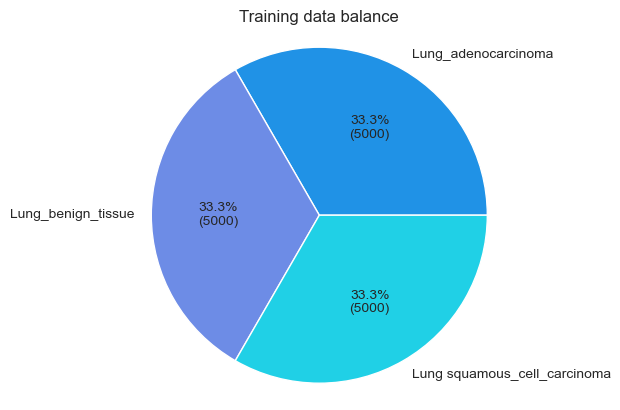

In [13]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

#### It is balanced, now we will split our data to train, val and test set

In [14]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=42)


### Create image data generator

#### In this step we will convert the whole data to numpy arrays

In [15]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


### Display sample for train data

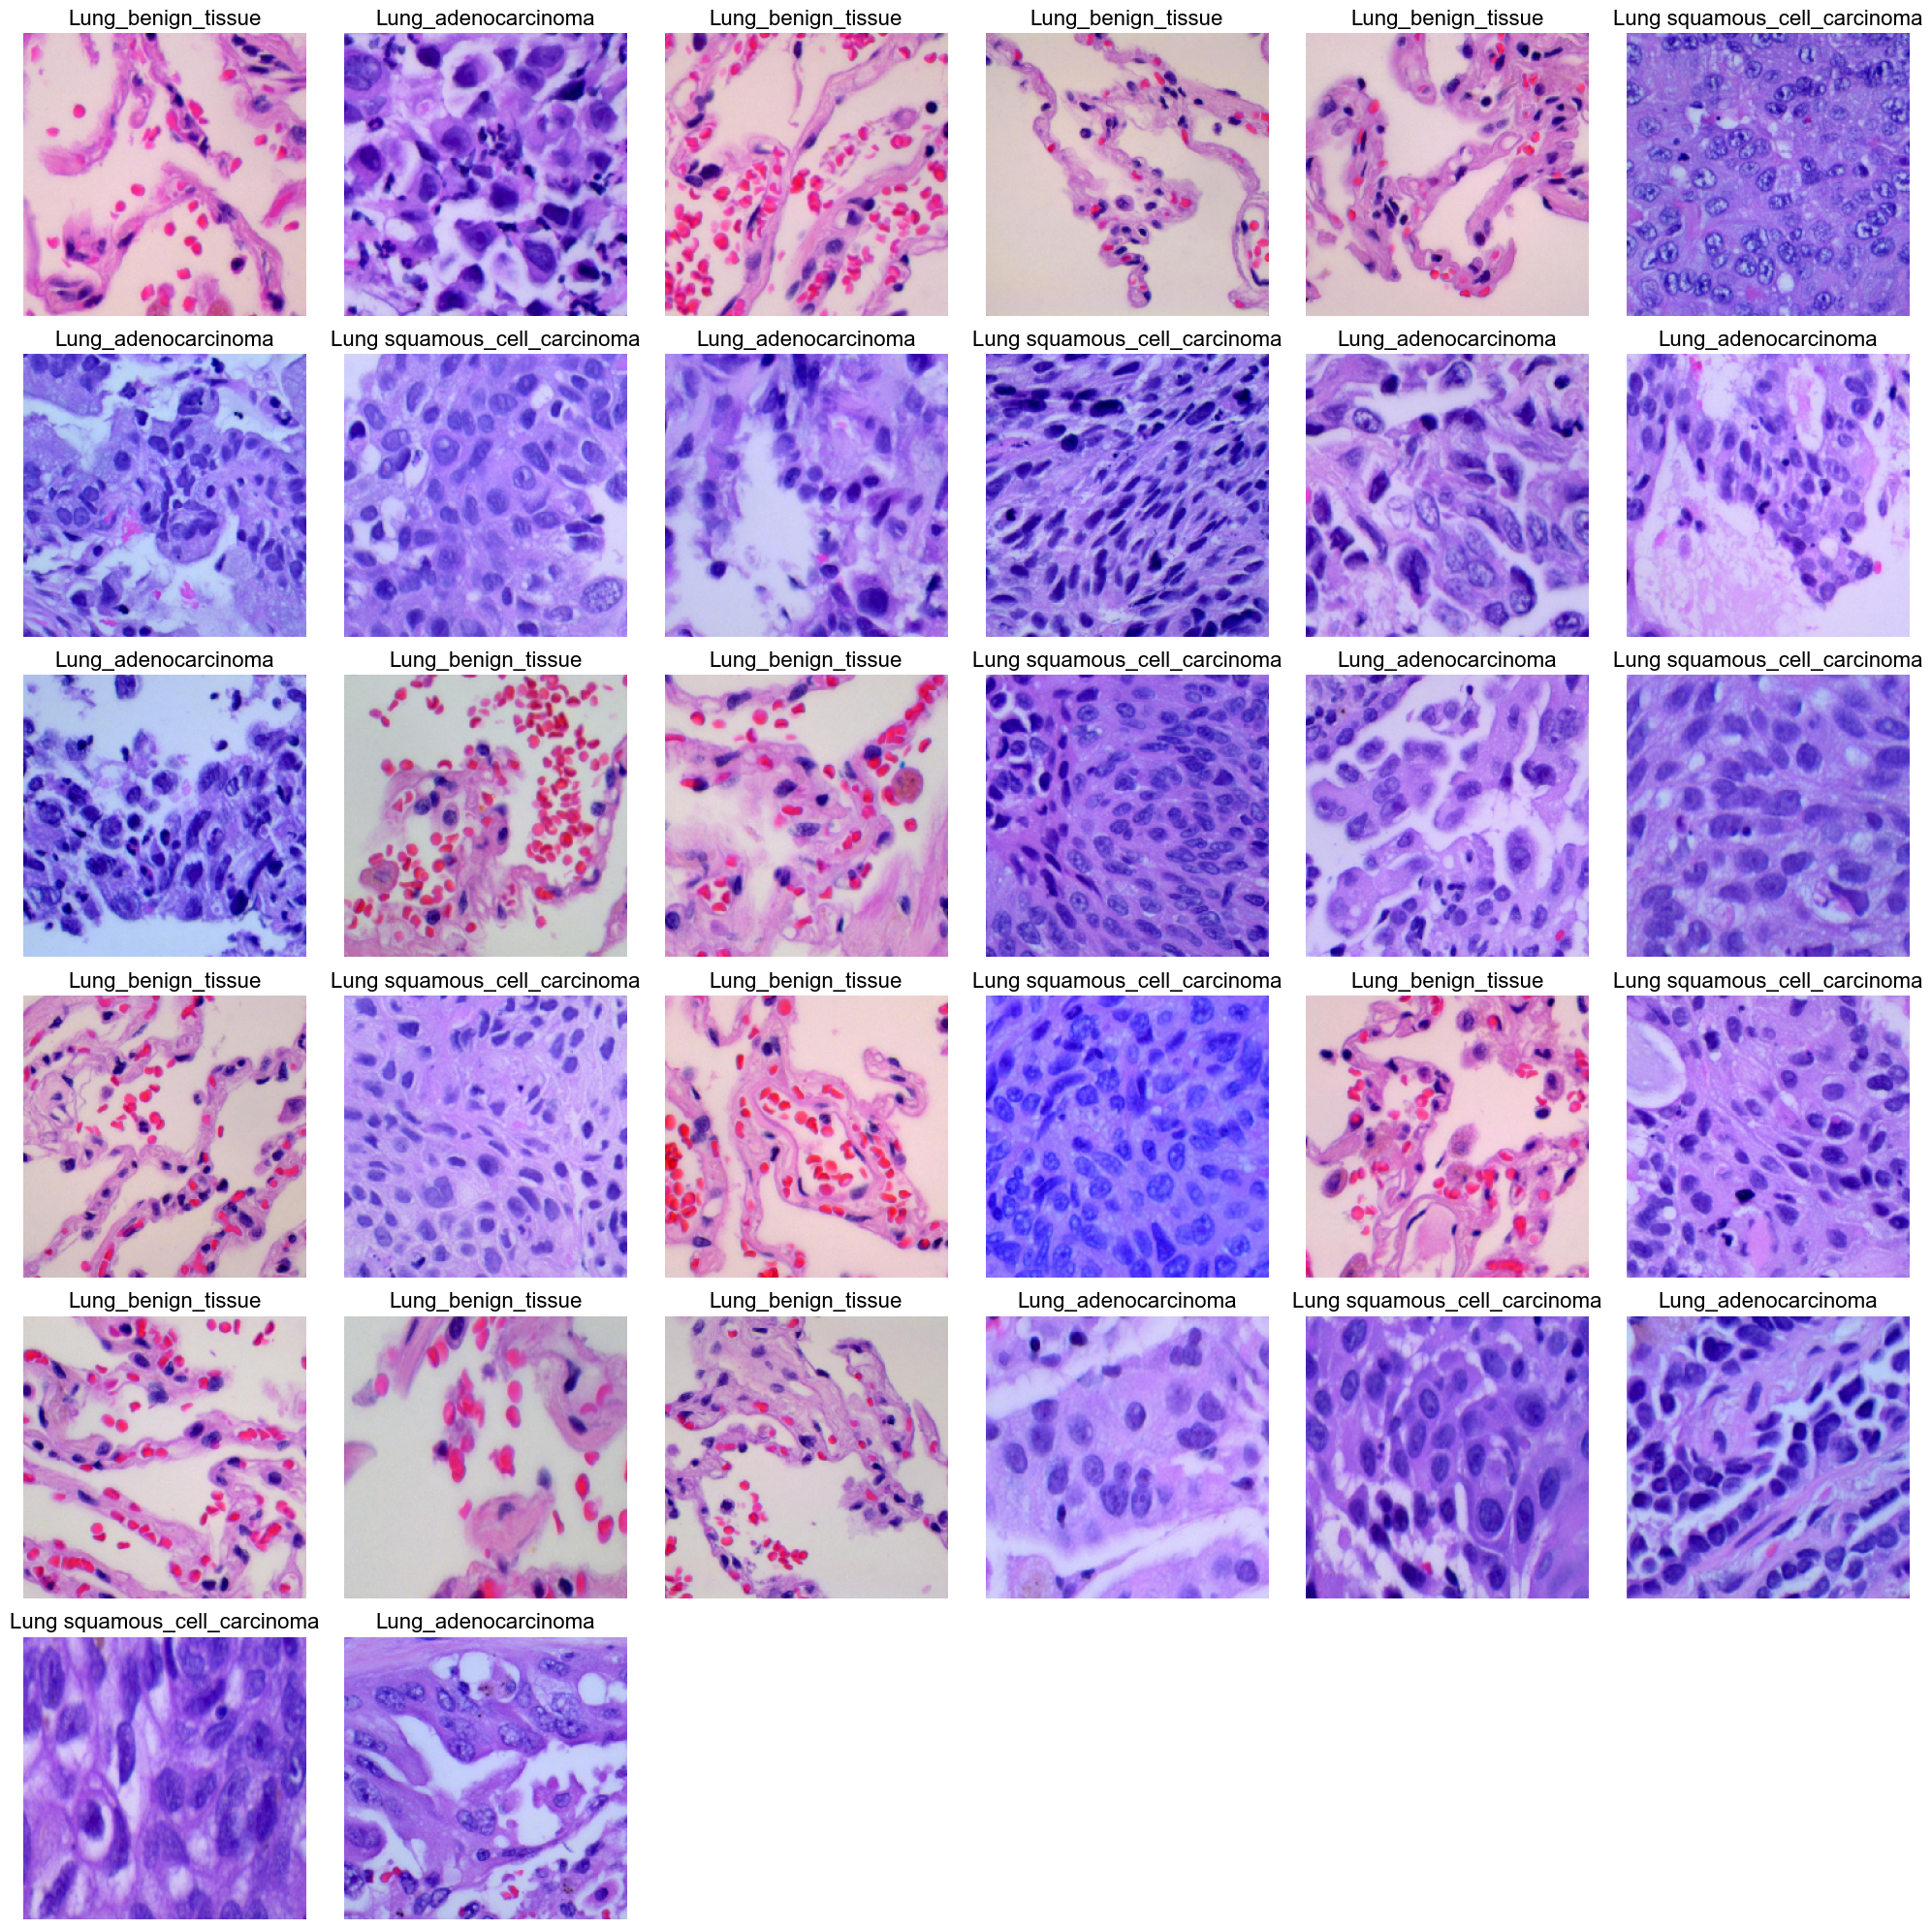

In [16]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Create needed function

In [22]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

# Model Structure

## CNN Model

In [23]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [24]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))
# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [25]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,523 (10.66 MB)

 Trainable params: 2,794,083 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [26]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.7825 - loss: 0.5821 - val_accuracy: 0.3340 - val_loss: 7.6007
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3793s 10s/step - accuracy: 0.9180 - loss: 0.2316 - val_accuracy: 0.9320 - val_loss: 0.1669
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9398 - loss: 0.1658 - val_accuracy: 0.9620 - val_loss: 0.0978
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.9518 - loss: 0.1307 - val_accuracy: 0.9453 - val_loss: 0.1556
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.9577 - loss: 0.1228 - val_accuracy: 0.9760 - val_loss: 0.0669
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.9616 - loss: 0.1106 - val_accuracy: 0.9593 - val_loss: 0.1118
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.9668 - loss: 0.0949 - val_accuracy: 0.9507 - val_loss: 0.1176
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1036s 3s/step - accuracy: 0.9781 - loss: 0.0705 - val_a

### Display model performance

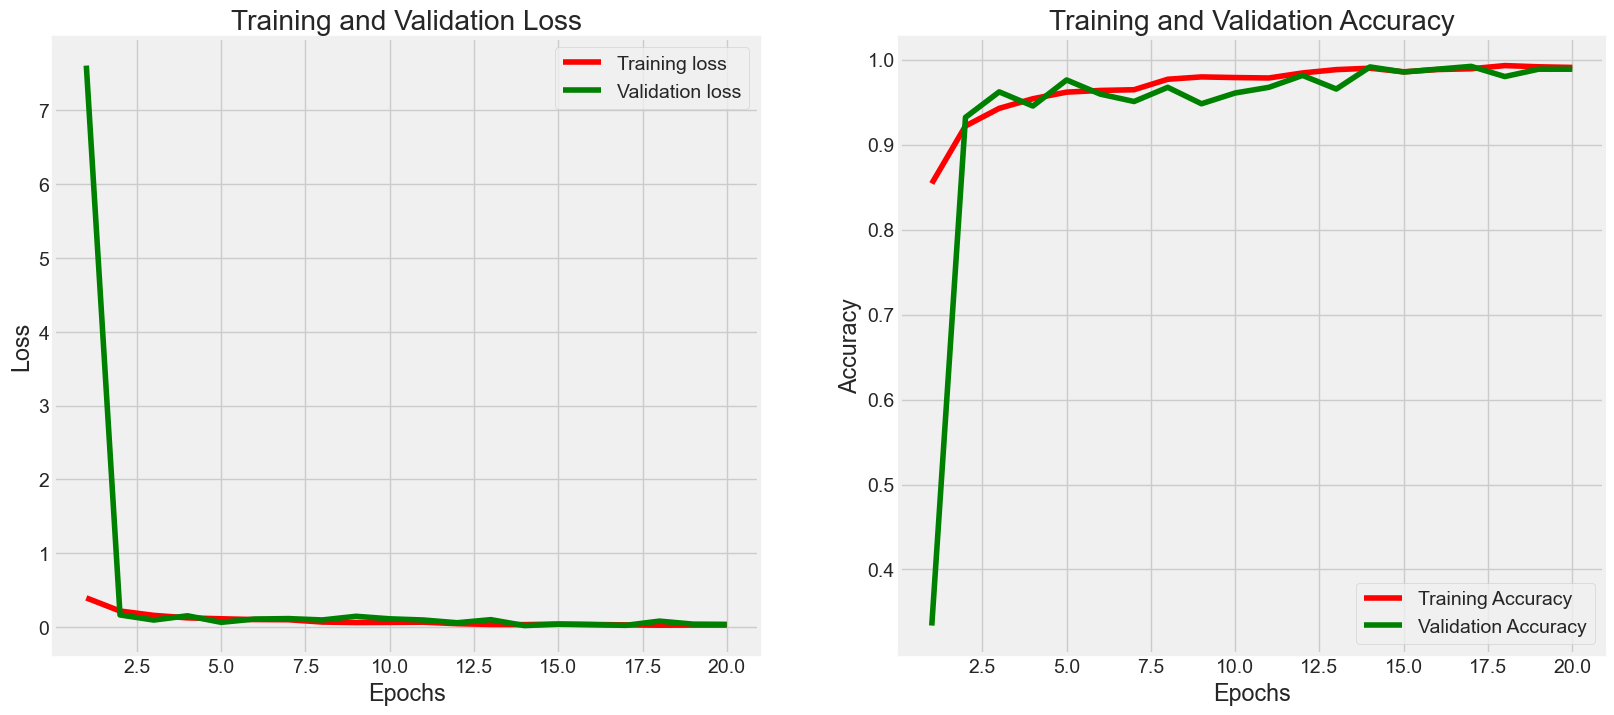

In [28]:
# Display model performance
model_performance(history, epochs)

### Evaluate the model

In [29]:
# Model evaluation
model_evaluation(cnn_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 192s 512ms/step - accuracy: 0.9985 - loss: 0.0037
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 519ms/step - accuracy: 0.9901 - loss: 0.0298
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.9927 - loss: 0.0172
Train Loss:  0.003517577890306711
Train Accuracy:  0.9988333582878113
--------------------
Validation Loss:  0.03988543152809143
Validation Accuracy:  0.9886666536331177
--------------------
Test Loss:  0.021151896566152573
Test Accuracy:  0.9913333058357239


### Get Prediction and display the confusion matrix

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 513ms/step


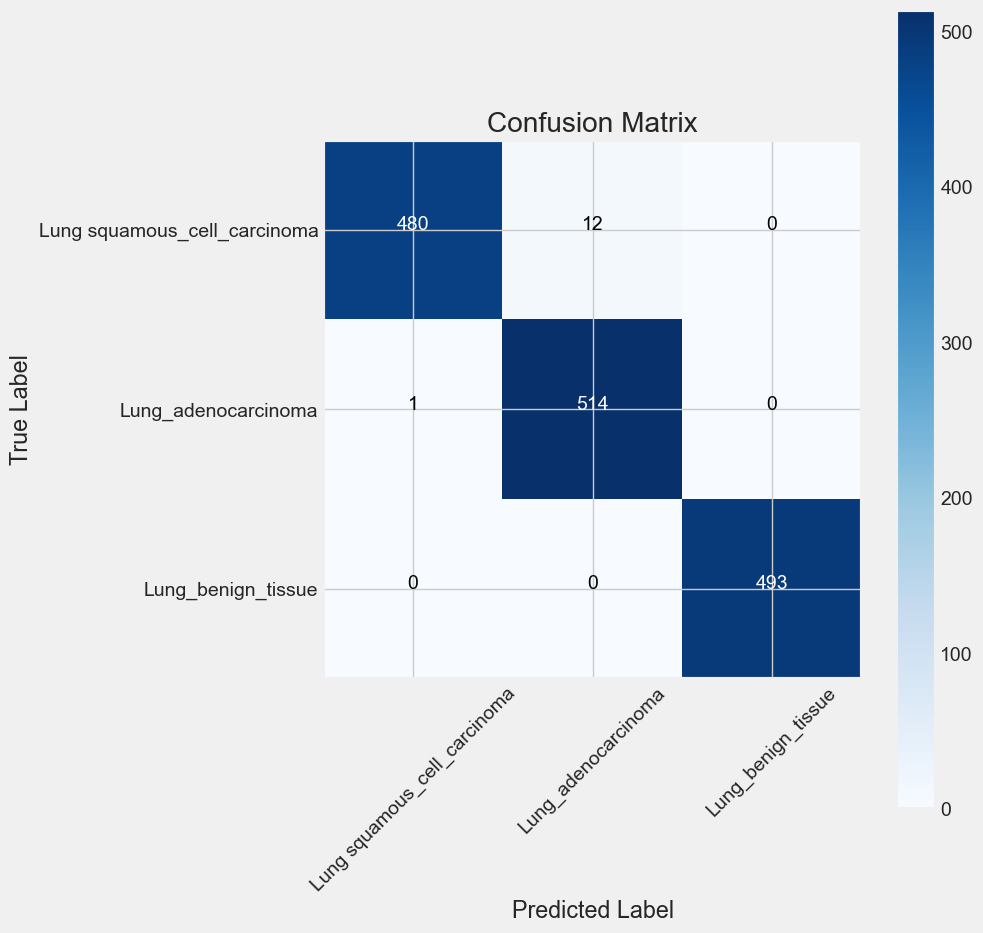

In [30]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

## EfficientNetB3

In [32]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [33]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [ ]:
# train the model
epochs = 20   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9713s 25s/step - accuracy: 0.6818 - loss: 0.7396 - val_accuracy: 0.3467 - val_loss: 1.3403
Epoch 2/20
  6/375 ━━━━━━━━━━━━━━━━━━━━ 10:29:53 102s/step - accuracy: 0.8533 - loss: 0.3731

### Display model performance

In [ ]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

### Evaluate the model

In [ ]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

### Get Prediction and display the confusion matrix

In [ ]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)